# Guided Test Case Generation System Notebook

In [9]:
# Basic libraries
import os, sys
import numpy as np
import re
import string
from datetime import datetime
import math
import pandas as pd

import utils, constant

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Speech
import soundfile as sf # pip install pysoundfile
import python_speech_features as speech_lib # pip install python_speech_features


# Machine learning
import nltk
from sklearn.utils import shuffle
from sklearn.base import clone as clone_model
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import joblib


%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
!python --version

Python 3.7.3


### Read Data

In [23]:
SR = constant.SR
TTS = constant.GOOGLE

df = {}
for sr in SR :
    df[sr] = utils.read_data("data/" + TTS + "/" + sr + "/training_data.txt")

    
# fpath = "data/google/wit/training_data.txt"

# df = pd.read_csv(fpath, sep=",", header=None)

In [27]:
for key in df.keys() :
    print("\n\n\n")
    print(key)
    print(df[key].groupby("label").describe())





deepspeech
      sentence                                                               
         count unique                                                top freq
label                                                                        
-1        2060   2060  the aim of this report is not only to enhance ...    1
 0       14195  14195  in reply to the two questions put respectively...    1
 1        3745   3745  the proposals will put us in a stronger positi...    1




wit
      sentence                                                               
         count unique                                                top freq
label                                                                        
-1         383    383          that is a more specific way of putting it    1
 0       14195  14195  in reply to the two questions put respectively...    1
 1        5422   5422  we are receiving the message that the aspirati...    1




wav2letter
      sentence            

### Data distribution





deepspeech


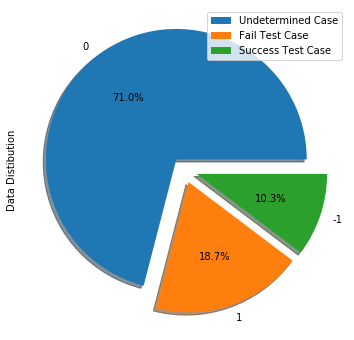





wit


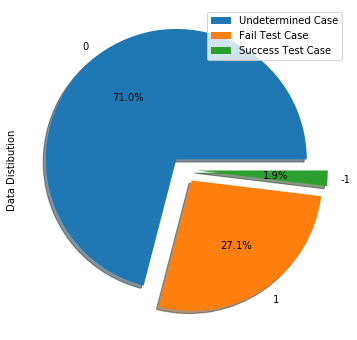





wav2letter


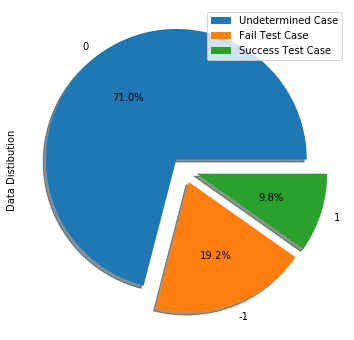





paddledeepspeech


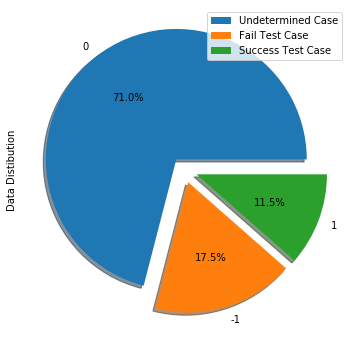

In [25]:
for key in df.keys() :
    print("\n\n\n")
    print(key)
    # print(df[key].groupby("label").describe())
    df[key]["label"].value_counts().plot(kind = 'pie', explode = [0.1, 0.1, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
    plt.ylabel("Data Distibution")
    plt.legend(["Undetermined Case", "Fail Test Case", "Success Test Case"])
    plt.show()

we need to handle imbalance data

### Handle Imbalance Data

Resample Size: 7362


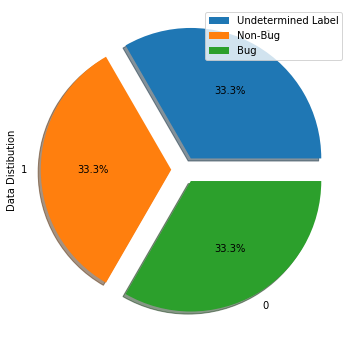

In [7]:
RESAMPLE_SIZE = utils.getResampleSize(df)
print("Resample Size: %d" % RESAMPLE_SIZE)

sample = utils.resampleToFixNumber(df["deepspeech"], RESAMPLE_SIZE)
sample["label"].value_counts().plot(kind = 'pie', explode = [0.1, 0.1, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Data Distibution")
plt.legend(["Undetermined Label", "Non-Bug", "Bug"])
plt.show()

### Feature Extraction

In [8]:
NUM_CORES = 4
EMBEDDING_SIZE = 13

In [9]:
from gensim.models import Word2Vec

corpus_sentence = pd.read_csv('corpus-sentence.txt', sep=",", header=None)
corpus_sentence.columns = ["sentence"]
tokenized_corpus = list(corpus_sentence['sentence'].apply(utils.text_process))

w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    size=EMBEDDING_SIZE,
    min_count=1,
    window=5,
    workers=NUM_CORES,
    seed=1337
)

w2v_model.save("model/word2vec.model")

# Show that similar words to 'program' print
# w2v_model.wv.most_similar(positive='program')

# Encode the documents using the new embedding
encoded_docs = [[w2v_model.wv[word] for word in sentence] for sentence in tokenized_corpus]

### Length variation on each sentence

In [10]:
print(len(encoded_docs[0]))
print(len(encoded_docs[1])) 
# print(encoded_docs[0]) 

42
40


In [11]:
def max_length_sentence_from_corpus(encoded_docs):
    max = 0
    for encoded_sentence in encoded_docs :
        if (len(encoded_sentence) > max) :
            max = len(encoded_sentence)
    return max


MAX_LENGTH = max_length_sentence_from_corpus(encoded_docs)
MAX_LENGTH

75

In [12]:
# because the length of each sentence is various 
# and we use non-sequential machine learning model
# we need to make padding for each sentences
def create_padding_on_sentence(encoded_docs) :
    padded_posts = []

    for post in encoded_docs:

        # Pad short posts with alternating min/max
        if len(post) < MAX_LENGTH:

            padding_size = MAX_LENGTH - len(post)

            for _ in range(0, padding_size) :
                post.append(np.zeros((EMBEDDING_SIZE)))


        # Shorten long posts or those odd number length posts we padded to MAX_LENGTH
        if len(post) > MAX_LENGTH:
            post = post[:MAX_LENGTH]

        # Add the post to our new list of padded posts
        padded_posts.append(post)
    
    return padded_posts

In [13]:
def flatten_docs(padded_docs) :
    flatten = []
    for sentence in padded_docs:
        ps = []
        for word in sentence :
            for feature in word :
                ps.append(feature)
        flatten.append(ps)
    return np.asarray(flatten)

In [14]:
temp_data = utils.resampleToFixNumber(df["deepspeech"], RESAMPLE_SIZE)
temp_data = utils.shuffle_data(temp_data)

In [15]:
temp_data.head()

,sentence,label
0,chapter seven going to nome one beautiful day ...,-1
1,don't be ugly and obstinate but think real har...,1
2,which had become perfectly level had the appea...,-1
3,has been wickedly deserted on the desert coast...,1
4,and no measure for the deep waters neither is ...,1


In [16]:
def extract_feature(docs) :
    tokenized_sentences = docs.apply(utils.text_process)
    encoded_docs = [[w2v_model.wv[word] for word in sentence] for sentence in tokenized_sentences]
    padded_docs = create_padding_on_sentence(encoded_docs)
    flatten_array = flatten_docs(padded_docs)
    return flatten_array

In [17]:
temp_data["sentence"][0]

'chapter seven going to nome one beautiful day in the spring of nineteen hundred i sailed again for alaska this time for nome from san francisco'

In [18]:
flatten_array = extract_feature(temp_data['sentence'])

In [19]:
# flatten_array[0]

In [20]:
# https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = RandomForestClassifier(n_estimators=31, random_state=111)

    
    score = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8,shuffle=True), n_jobs=2, verbose=2)
    return np.mean(score)

In [ ]:
evaluate_features(flatten_array, temp_data["label"])

## Experiment

### Prepare Model

In [21]:
N_JOBS = 4

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=10)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='lbfgs', n_jobs=N_JOBS)
rfc = RandomForestClassifier(n_estimators=31, random_state=111, n_jobs=N_JOBS)
abc = AdaBoostClassifier(n_estimators=31, random_state=111)
bc = BaggingClassifier(n_estimators=10, random_state=111, n_jobs=N_JOBS)
etc = ExtraTreesClassifier(n_estimators=10, random_state=111, n_jobs=N_JOBS)
xgb = xgboost.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)

In [22]:
clfs = {'SVC' : svc,'KN' : knc, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc }

### Model Evaluation

In [23]:
features = {}
labels = {}
for k,v in df.items() :
    data = utils.resampleToFixNumber(v, RESAMPLE_SIZE)
    features[k] = extract_feature(data["sentence"])
    labels[k] = data["label"]

#### Performance

In [ ]:
for clf_name, clf in clfs.items() :
    accuracy = []
    for k,v in df.items() :
        acc = evaluate_features(features[k], labels[k], clf)
        accuracy.append(acc)

    print('Average accuracy %s: %.2f' % (clf_name, np.mean(accuracy)))

### Trying Model in the First Batch

In [24]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
    
def predict_labels(clf, features):
    return clf.predict(features)

# intersection between 2 sets
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

In [25]:
k = list(df.keys())[0]
FIRST_BATCH_SIZE = math.ceil(len(df[k]["label"]) * 3 / 4 )
BATCH_SIZE = math.ceil(len(df[k]["label"]) / 2 / 3)
MAX_SIZE = len(df[k]["label"])

features = {}
labels = {}
for k,v in df.items() :
    data = v[:FIRST_BATCH_SIZE]
    data = utils.resampleToFixNumber(data, RESAMPLE_SIZE)
    features[k] = extract_feature(data["sentence"])
    labels[k] = data["label"]

In [26]:
models = {}
# selected_clfs = ["SVC", "KN", "NB", "DT", "LR", "RF", "AdaBoost", "BgC", "ETC", "XGB"]
# selected_clfs = ["SVC", "KN", "NB", "DT", "LR", "AdaBoost", "XGB"]
selected_clfs = ["RF"]
# selected_clfs = ["KN", "DT", "LR", "RF", "AdaBoost", "ETC"]
for k in selected_clfs :
    per_sr_model = {}
    for key_sr in features.keys() :
        model = None
        model = clone_model(clfs[k])
        train_classifier(model, features[key_sr], labels[key_sr])
        per_sr_model[key_sr] = model
    models[k] = per_sr_model
    
# for clf in models.keys() :
#     for sr in models[clf].keys():
#         filename = "model/" + clf + "_" + sr + ".sav"
#         joblib.dump(models[clf][sr], filename)

### Trying Model for the Next Batch until Finish

In [27]:
performance_writer = open(
        "performance/word2vec_" + str(datetime.now()) + ".txt", "w+")


for key_clf, v in models.items() :
    # classify the selected data
    training_data = {}
    for key_sr, model in v.items():
        training_data[key_sr] = df[key_sr][:FIRST_BATCH_SIZE]

    lower_bound = FIRST_BATCH_SIZE

    columns = ["True", "Positive", "TP", "Precision", "Recall", "F1"]
    index = []
    performance_data = []

    while (lower_bound < MAX_SIZE) :
        # set the upper bound size
        upper_bound = lower_bound + BATCH_SIZE
        if (upper_bound > MAX_SIZE) :
            upper_bound = MAX_SIZE
        batch = str(lower_bound) + " - " + str(upper_bound)
        index.append(batch)
            
        
        df_per_batch = {}
            
        for key_sr, model in v.items():
            # get the data to be selected
            current_data = df[key_sr][lower_bound:upper_bound]
            
            # get the feature and label
            current_features = extract_feature(current_data["sentence"])
            current_labels = current_data["label"]

            # predict the current data
            pred = predict_labels(model, current_features)
            
            d = {
                 "label" : current_data["label"].values,
                 "prediction" : pred
                }
            
            
            df_per_batch[key_sr] = pd.DataFrame(data=d)

        
        predicted_fail_test_case = utils.get_fail_test_case(df_per_batch, "prediction")
        actual_fail_test_case = utils.get_fail_test_case(df_per_batch, "label")
        
        correctly_predicted_fail_test_case = utils.intersection(predicted_fail_test_case, actual_fail_test_case)
        
        
        precision = 0
        if (len(predicted_fail_test_case) != 0) :
            precision = round(len(correctly_predicted_fail_test_case)/len(predicted_fail_test_case), 2)
        recall = 0
        if (len(actual_fail_test_case) != 0) :
            recall = round(len(correctly_predicted_fail_test_case)/len(actual_fail_test_case), 2)
        precision_add_recall = precision + recall
        f1 = 0
        if precision_add_recall != 0 :
            f1 = round( 2 * precision * recall / (precision_add_recall), 2)
        performance_data.append(
            [len(actual_fail_test_case), 
             len(predicted_fail_test_case), 
             len(correctly_predicted_fail_test_case), 
             precision, recall, f1])
        
        # add the predicted data to previous data
        if (len(correctly_predicted_fail_test_case) > 0) :
            for key_sr in df_per_batch.keys() :
                added_data = current_data.iloc[correctly_predicted_fail_test_case,:]
                training_data[key_sr].append(added_data)
                
                # handle imbalance data
                resampled_data = utils.resampleToFixNumber(training_data[key_sr], RESAMPLE_SIZE)

                # re-extract feature
                features[key_sr] = extract_feature(resampled_data["sentence"])
                labels[key_sr] = resampled_data["label"]

                # re-train the model 
                train_classifier(model, features[key_sr], labels[key_sr])

        # update the lower bound
        lower_bound = upper_bound

    performance = pd.DataFrame(performance_data, index=index, columns=columns)
    
    print("Classifier: " + key_clf) 
    print(performance)
    actual_fail_test_case =  int(performance["True"].sum(axis=0))
    predicted_fail_test_case = int(performance["Positive"].sum(axis=0))
    correctly_predicted_fail_test_case = int(performance["TP"].sum(axis=0))
    precision = round(performance["Precision"].mean(), 2)
    recall = round(performance["Recall"].mean(), 2)
    f1 = round(performance["F1"].mean(), 2)
    
    print("Actual Fail Test Case: %d" % (actual_fail_test_case))
    print("Predicted Fail Test Case: %d" % (predicted_fail_test_case))
    print("Correctly Predicted Fail Test Case: %d" % (correctly_predicted_fail_test_case))
    print("Precision: %.2f" % (precision))
    print("Recall: %.2f" % (recall))
    print("F1: %.2f" % (f1))
    print("\n")
    
    performance_writer.write("Classifier: %s" % (key_clf))
    performance_writer.write("\n" + str(performance))
    performance_writer.write("\nActual Fail Test Case: %d" % (actual_fail_test_case))
    performance_writer.write("\nPredicted Fail Test Case: %d" % (predicted_fail_test_case))
    performance_writer.write("\nCorrectly Predicted Fail Test Case: %d" % (correctly_predicted_fail_test_case))
    performance_writer.write("\nPrecision: %.2f" % (precision))
    performance_writer.write("\nRecall: %.2f" % (recall))
    performance_writer.write("\nF1: %.2f" % (f1))
    performance_writer.write("\n\n")

performance_writer.close()

KeyboardInterrupt: 